In [1]:
import os
import gzip
import pandas as pd
import matplotlib.pyplot as plt

## 1. Load data

* **Source**: [BG WordLists](https://github.com/miglen/bulgarian-wordlists)

In [2]:
# Read the csv file in the gzip archive
words_df = pd.read_csv('data/4_bg_wordlists.txt.gz', encoding='windows-1251', sep='\t', compression='gzip', header=None, names=['word'])
words_df.index.name = 'id'
print(f"Total words count: {len(words_df):,}")
words_df.head(10)

Total words count: 234,114


,word
id,
0,ай
1,аз
2,ад
3,ал
4,ар
5,ат
6,ас
7,ах
8,ба


## 2. Remove spaced words

In [3]:
spaced_words = words_df[words_df['word'].str.contains(" ")]
print(f"Number of spaced words: {len(spaced_words):,}")

Number of spaced words: 0


## 3. Remove dashed words

In [4]:
dashed_words = words_df[words_df['word'].str.contains("-")]
print(f"Number of dashed words: {len(dashed_words):,}")

Number of dashed words: 120


In [5]:
# Remove words with spaces
words_df = words_df[~words_df['word'].str.contains("-")]
print(f"Total words count (after dashed words removal): {len(words_df):,}")

Total words count (after dashed words removal): 233,994


Add dashed-word parts as new words in the dataset.

In [6]:
# Split the words into parts and keep them as a set.
dashed_words_parts = dashed_words['word'].str.split("-")
# Flatten the list and convert to set (no duplicates)
dashed_words_parts = set([part for parts in dashed_words_parts for part in parts])
# Print the number of unique parts
print(f"Number of unique parts: {len(dashed_words_parts):,}")
# Print the parts
print(list(dashed_words_parts)[:30])

Number of unique parts: 210
['суровинен', 'санитарно', 'политически', 'помощник', 'храм', 'студентка', 'следствен', 'продажба', 'фризьорски', 'касиер', 'брилянт', 'жълто', 'парк', 'розово', 'причинно', 'заместник', 'икономически', 'етичен', 'природо', 'гръцки', 'българско', 'черно', 'психо', 'възпитателен', 'частица', 'година', 'изпълнител', 'що', 'пренос', 'пощенски']


In [7]:
# Identify missing words, that could be added to the words_df set
words_set = set(words_df['word'].values)
dashed_parts_diff = set(dashed_words_parts) - words_set
print(f"Number of missing parts: {len(dashed_parts_diff):,}")
print(sorted(dashed_parts_diff))

Number of missing parts: 22
['бръснаро', 'българо', 'газо', 'зидаро', 'историко', 'капсул', 'кирило', 'лирико', 'литературан', 'лозаро', 'мениджърски', 'методиевски', 'паричност', 'паров', 'покупко', 'пощенец', 'природо', 'телеграфо', 'товаро', 'физико', 'фолкфест', 'химико']


There are few invalid Bulgarian words, that we'll ignore (`кирило`, `методиевски`, `литературан` ...)

In [8]:
# Remove words that are not valid Bulgarian words
dashed_parts_diff = set(dashed_parts_diff) - set(['кирило', 'методиевски', 'литературан'])
# Insert the missing parts into the words_df
words_df = pd.concat([words_df, pd.DataFrame({'word': list(dashed_parts_diff)})])
# Print the new size
print(f"Total words count (after inserting missing parts): {len(words_df):,}")

Total words count (after inserting missing parts): 234,013


## 4. Remove capitalized words (names)

In [9]:
# Extract all names that start with a capital letter
names_df = words_df[words_df['word'].str.match(r'^[А-Я]')]
print(f"Number of names: {len(names_df):,}")

Number of names: 0


* **OBSERVATION**: No names in the set. At least with capitalized first-letter. :)

## 5. Check 1-letter words

In [10]:
# One letter words
one_letter_words = words_df[words_df['word'].str.len() == 1]
print(f"Number of one letter words: {len(one_letter_words):,}")

Number of one letter words: 0


## 6. Check 2-letter words

In [11]:
# Two letter words
two_letter_words = words_df[words_df['word'].str.len() == 2]
print(f"Number of two letter words: {len(two_letter_words):,}")
# Print all the 2-letter words
print(sorted(two_letter_words['word'].tolist()))

Number of two letter words: 88
['ад', 'аз', 'ай', 'ал', 'ар', 'ас', 'ат', 'ах', 'ба', 'бе', 'би', 'ви', 'вя', 'ги', 'го', 'да', 'де', 'де', 'до', 'ду', 'еж', 'ей', 'ек', 'ел', 'ех', 'за', 'зя', 'из', 'им', 'ки', 'ла', 'ле', 'ли', 'ли', 'ля', 'ма', 'ме', 'ми', 'му', 'на', 'не', 'ни', 'но', 'ню', 'ой', 'ок', 'ос', 'от', 'ох', 'па', 'пи', 'по', 'пя', 'ри', 'ря', 'са', 'се', 'си', 'ся', 'та', 'те', 'ти', 'то', 'ту', 'тя', 'уж', 'ум', 'уф', 'ух', 'ха', 'хе', 'хи', 'хм', 'че', 'чу', 'ши', 'ща', 'ще', 'що', 'щя', 'юг', 'юз', 'яд', 'яж', 'яз', 'як', 'ял', 'ям']


* **OBSERVATION**: Few words looked suspicious (e.g. `ал`, `ел`, `ле`), but IBS BAS dictionary confirmed they are valid words.

## 7. Remove Latin symbols

In [12]:
# Print words that contain latin symbols
latin_words = words_df[words_df['word'].str.contains(r'[a-zA-Z]')]
print(f"Number of words with latin symbols: {len(latin_words):,}")

Number of words with latin symbols: 0


* **OBSERVATION**: No latin symbols. That's cool!

## 8. Remove punctuation & digits

In [13]:
# Is there words with anything different than letters?
print(f"Number of words with anything different than letters: {words_df[words_df['word'].str.contains(r'[^\w]')].shape[0]:,}")

Number of words with anything different than letters: 0


* **OBSERVATION**: No punctuation and digits. That's great!

## 9. Remove duplicates

In [14]:
# Print duplicated words
duplicates_df = words_df[words_df.word.duplicated()]
print(f"Duplicated words: {duplicates_df.word.tolist()}")
# Remove duplicates
words_df = words_df.drop_duplicates(subset=['word'])
print(f"Total words count (after removing duplicates): {len(words_df):,}")

Duplicated words: ['де', 'ли']
Total words count (after removing duplicates): 234,011


* **OBSERVATION**: Two duplicates only. Hmm, quite bizarre.

## 10. Length distribution

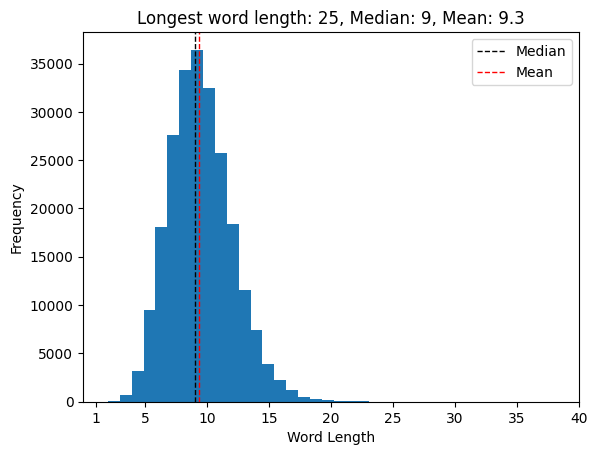

In [15]:
word_lengths = words_df['word'].str.len()
mean_length = word_lengths.mean()
median_length = word_lengths.median()
word_longest = word_lengths.max()
plt.hist(word_lengths, bins=word_longest-1)
plt.axvline(median_length, color='black', linestyle='dashed', linewidth=1)
plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=1)
plt.legend(['Median', 'Mean'])
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title(f'Longest word length: {word_longest}, Median: {median_length:.0f}, Mean: {mean_length:.1f}')
plt.xticks([1, 5, 10, 15, 20, 25, 30, 35, 40])
plt.xlim(0, 40)
plt.show()

* **OBSERVATION**: Interesting! We have a new distribution here. The longest word (25-letters) is within current range of longest words $[20-40]$. However, the median and the mean are lower than everything so far.

## 11. Merge with vocabulary

So far, we had `1 228 263` unique valid Bulgarian words in our vocabulary. Let's see what will be the merged set size.

In [16]:
# Read our vocabulary
vocab_df = pd.read_csv('data/words.txt.gz', encoding='windows-1251', header=None, compression='gzip')
vocab_set = set(vocab_df[0].tolist())
print(f"Number of words in vocabulary: {len(vocab_set):,}")

# Current set
bg_dict_words_set = set(words_df['word'].tolist())

# Let's merge the two sets
merged_vocab_set = vocab_set.union(bg_dict_words_set)

# Print the new words
print(sorted(merged_vocab_set - vocab_set))

Number of words in vocabulary: 1,228,263
['абаджиев', 'абеба', 'абиджан', 'абрашев', 'абу', 'абърдийн', 'августин', 'авджиев', 'авестан', 'авив', 'аврам', 'аврамов', 'австралия', 'австрия', 'агов', 'адам', 'аделаида', 'аделина', 'аден', 'аджемов', 'адис', 'адриан', 'адрианов', 'азербайджан', 'азия', 'азманов', 'айвазов', 'айков', 'айланд', 'айнщайн', 'айрес', 'айтос', 'аквитания', 'аконкагуа', 'аксиния', 'ал', 'аладжов', 'аладин', 'албания', 'албена', 'алгол', 'алдинов', 'алеков', 'алекс', 'александра', 'александрина', 'александрия', 'александров', 'александър', 'алексеев', 'алексей', 'алекси', 'алексиев', 'алексов', 'алжир', 'алипиев', 'алма', 'алмира', 'алпи', 'алпите', 'алтай', 'алтънов', 'алфред', 'алчев', 'альоша', 'аляска', 'амадеус', 'амалиев', 'амалия', 'аман', 'амбарев', 'америка', 'аминстия', 'амстердам', 'амундсеново', 'ана', 'анадир', 'анадола', 'ананиев', 'ананий', 'анастас', 'анастасия', 'анастасов', 'анатолий', 'анатолов', 'аначков', 'ангара', 'ангелиев', 'ангелина', 'ан

* **OBSERVATION**: Hmm, the new words look like **names**. Then, we are not adding them to our vocabulary. We don't need any pollution.

Only a **single valuable word** was found.

In [17]:
# Add the new word
vocab_set.add('ящен')

# Sort and dump the new vocabulary
words = sorted(list(vocab_set))
with open('data/words.txt', 'w', encoding='windows-1251') as f:
    for word in words:
        f.write(word + '\n')

# Convert to gzip
with open('data/words.txt', 'rb') as f_in:
    with gzip.open('data/words.txt.gz', 'wb') as f_out:
        f_out.writelines(f_in)

# Remove the original file
os.remove('data/words.txt')

print(f"Number of words written to file: {len(words):,}")

Number of words written to file: 1,228,264
